# Beiwe, Fitbit, and REDCap
Analysis across all three modalities

In [198]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sleep Comparison
All three of these modalities provide a measurement of the Total Sleep Time (TST) for our participants:
* Beiwe: Question on the morning EMA
* Fitbit: Derived from sleep stage measurements
* REDCap: As part of the CRISIS surveys

There are obvious trends in TST from the CRISIS surveys at the three distinct time points so we can see if these trends hold when observing the other modalities. 

In [199]:
# general
import os
import sys
sys.path.append('../')
# user-defined functions
from src.visualization import visualize
# basic data science
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
# timeseries
from datetime import datetime, timedelta
# plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Data Import

## Beiwe

### UTx000

In [200]:
bw = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
bw = bw[["timestamp","redcap","tst"]]
bw["date"] = bw["timestamp"].dt.date
bw.drop("timestamp",axis="columns",inplace=True)
bw.head()

,redcap,tst,date
0,68,8.0,2020-05-13
1,28,2.0,2020-05-13
2,21,6.0,2020-05-13
3,29,5.3,2020-05-13
4,48,2.0,2020-05-13


### BPEACE

In [201]:
bw_bp = pd.read_csv("../data/processed/bpeace-morning-survey.csv",index_col=0,parse_dates=True,infer_datetime_format=True)
bw_bp["date"] = bw_bp.index.date
bw_bp = bw_bp[["tst","beiwe","date"]]
bw_bp.head()

,tst,beiwe,date
2020-02-03 10:06:25,6.5,6mkypp1o,2020-02-03
2020-03-01 19:01:45,9.5,6mkypp1o,2020-03-01
2020-02-28 08:06:27,6.5,6mkypp1o,2020-02-28
2020-02-21 07:30:11,5.5,6mkypp1o,2020-02-21
2020-02-10 10:25:38,6.5,6mkypp1o,2020-02-10


### Aggregate
We don't care about the IDs and the crossover between the participants (yet...) so we can just group everything into one dataframe

In [202]:
bw_agg = bw[["tst","date"]].append(bw_bp[["tst","date"]]).reset_index(drop=True)
bw_agg.head()

,tst,date
0,8.0,2020-05-13
1,2.0,2020-05-13
2,6.0,2020-05-13
3,5.3,2020-05-13
4,2.0,2020-05-13


## Fitbit

### UTx000

In [203]:
fb = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_date","end_date","end_time","start_time"],infer_datetime_format=True)
fb = fb[["tst_fb","redcap","end_date"]]
fb.columns = ["tst","redcap","date"]
fb.head()

,tst,redcap,date
0,6.316667,NaN,2020-05-14
1,6.533333,NaN,2020-05-15
2,4.783333,NaN,2020-05-16
3,6.716667,NaN,2020-05-17
4,5.850000,NaN,2020-05-18


### BPEACE

In [204]:
fb_bp = pd.read_csv("../data/raw/bpeace/fitbit/sleepDay_merged.csv",parse_dates=["SleepDay"],infer_datetime_format=True)
fb_bp["date"] = fb_bp["SleepDay"].dt.date
fb_bp = fb_bp[["Id","date","TotalMinutesAsleep"]]
fb_bp.columns = ["redcap","date","tst"]
fb_bp["tst"] /= 60
fb_bp.head()

,redcap,date,tst
0,101,2020-02-08,7.950000
1,101,2020-02-09,5.950000
2,101,2020-02-10,7.983333
3,101,2020-02-11,6.133333
4,101,2020-02-12,5.900000


### Aggregate
We don't care about the IDs and the crossover between the participants (yet...) so we can just group everything into one dataframe

In [205]:
fb_agg = fb[["tst","date"]].append(fb_bp[["tst","date"]]).reset_index(drop=True)
fb_agg["date"] = pd.to_datetime(fb_agg["date"])
fb_agg.head()

,tst,date
0,6.316667,2020-05-14
1,6.533333,2020-05-15
2,4.783333,2020-05-16
3,6.716667,2020-05-17
4,5.850000,2020-05-18


## REDCap

In [206]:
rc = pd.read_csv("../data/raw/utx000/surveys/CRISIS_all_raw.csv",usecols=[0,1,2,42],names=["pre","during","followup","redcap"],skiprows=1)
rc = rc.melt(id_vars="redcap",value_vars=["pre","during","followup"],var_name="period",value_name="tst_rating")
rc.head()

,redcap,period,tst_rating
0,1,pre,1.0
1,2,pre,1.0
2,4,pre,3.0
3,5,pre,2.0
4,6,pre,2.0


In [207]:
rc_agg = rc[["tst_rating","period"]]

# Encoding
The continuous measurements/reports from Fitbit/Beiwe need to be encoded to the same scale as the REDCap surveys.

4: TST > 10 <br>
3: 10 > TST > 8 <br>
2: 8 > TST > 6 <br>
1: TST < 6 <br>

In [208]:
def encode_sleep(tst):
    """encodes tst as a value"""
    if tst > 10:
        return 4
    elif tst > 8:
        return 3
    elif tst > 6:
        return 2
    else:
        return 1

In [209]:
bw_agg["tst_rating"] = bw_agg.apply(lambda x: encode_sleep(x["tst"]), axis="columns")
fb_agg["tst_rating"] = fb_agg.apply(lambda x: encode_sleep(x["tst"]), axis="columns")

# CRISIS Survey Period
Based on the timestamps from the surveys and Fitbit, we can determine which REDCap survey the reported/measured values correspond to.

In [210]:
def get_period(t):
    """gets the CRISIS period based on the given time t"""
    if t < datetime(2020,5,5).date():
        return "pre"
    elif t > datetime(2020,5,5).date() and t < datetime(2020,5,19).date():
        return "during"
    elif t > datetime(2020,6,10).date() and t < datetime(2020,6,24).date():
        return "followup"
    else:
        return np.nan

In [211]:
bw_agg["period"] = bw_agg.apply(lambda x: get_period(x["date"]), axis="columns")
fb_agg["period"] = fb_agg.apply(lambda x: get_period(x["date"]), axis="columns")

# Aggregate
We compare the aggregated TSTs.

In [215]:
def plot_tst_device(df,device="beiwe"):
    """Plots bar plot of TSTs from a certain device"""
    if device not in ["redcap"]:
        df_grouped = df.groupby(["period","tst_rating"]).count().drop("date",axis="columns").reset_index()
    else:
        df["tst"] = 1
        df_grouped = df.groupby(["period","tst_rating"]).count().reset_index()
    df_grouped.columns = ["period","tst_rating","n"]
    totals = df_grouped.groupby(["period"]).sum().drop("tst_rating",axis="columns").reset_index()
    df_grouped = df_grouped.merge(right=totals,on="period",how="left",suffixes=("_ind","_all"))
    df_grouped["p"] = df_grouped["n_ind"]/df_grouped["n_all"]
    
    fig, ax = plt.subplots(figsize=(20,5))
    bars = sns.barplot(x="tst_rating",y="p",hue="period",data=df_grouped,
                hue_order=["pre","during","followup"],palette=["seagreen","goldenrod","firebrick"],edgecolor="black",)
    # x-axis
    bars.set_xlabel("Total Sleep Time",fontsize=16)
    bars.set_xticklabels(["< 6 Hours","6-8 Hours","8-10 Hours", " > 10 Hours"],fontsize=14)
    #plt.xticks(fontsize=14)
    # y-axis
    bars.set_ylabel("Relative Percentage", fontsize=16)
    bars.set_ylim([0,1])
    plt.yticks(fontsize=14)
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    bars.legend(loc="upper left",title="Survey Period",title_fontsize=14,fontsize=12,frameon=False)
    
    plt.show()
    plt.close()
    
    return df_grouped

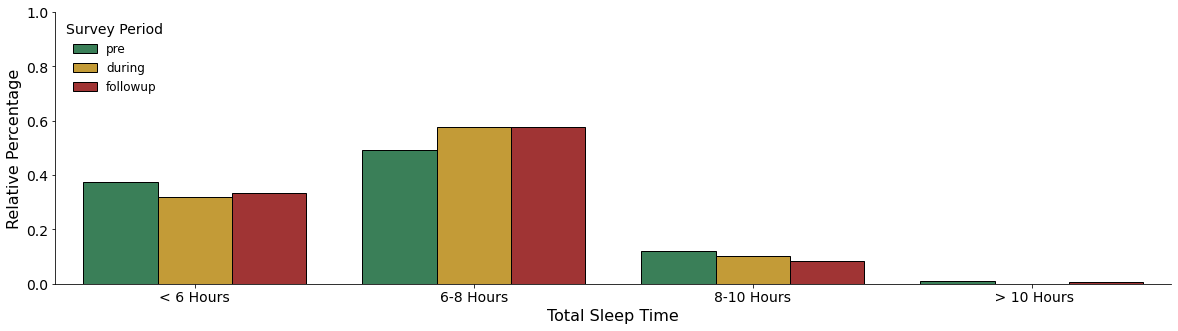

In [216]:
bw_comp = plot_tst_device(bw_agg)

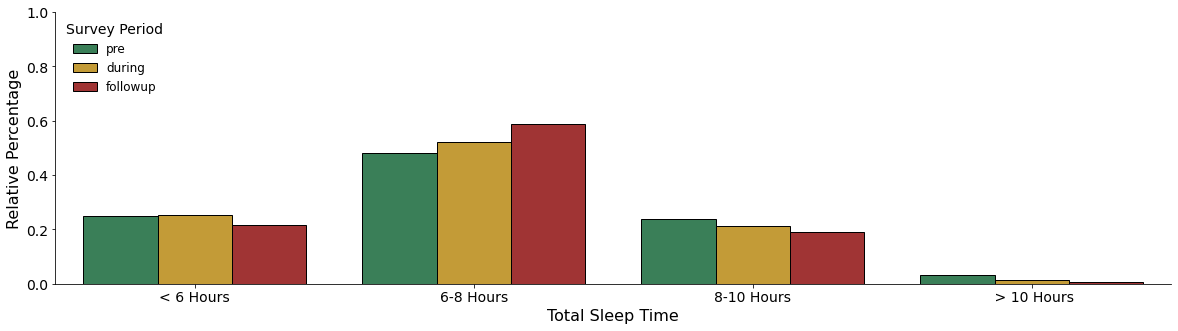

In [217]:
fb_comp = plot_tst_device(fb_agg)

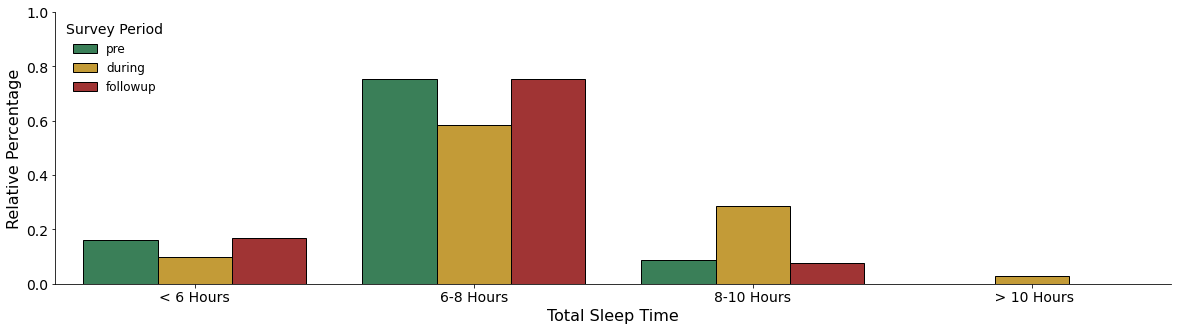

In [218]:
rc_comp = plot_tst_device(rc_agg, device="redcap")

## Direct Device Measurement Comparison

In [219]:
# adding device columns
rc_comp["device"] = "redcap"
fb_comp["device"] = "fitbit"
bw_comp["device"] = "beiwe"
# combining
#cols = ["period","tst_rating","device"]
all_agg = pd.concat([rc_comp,fb_comp,bw_comp])
#all_agg["n"] = 1 # dummy column
#all_agg = all_agg.groupby(["period","tst_rating","device"]).count().reset_index()

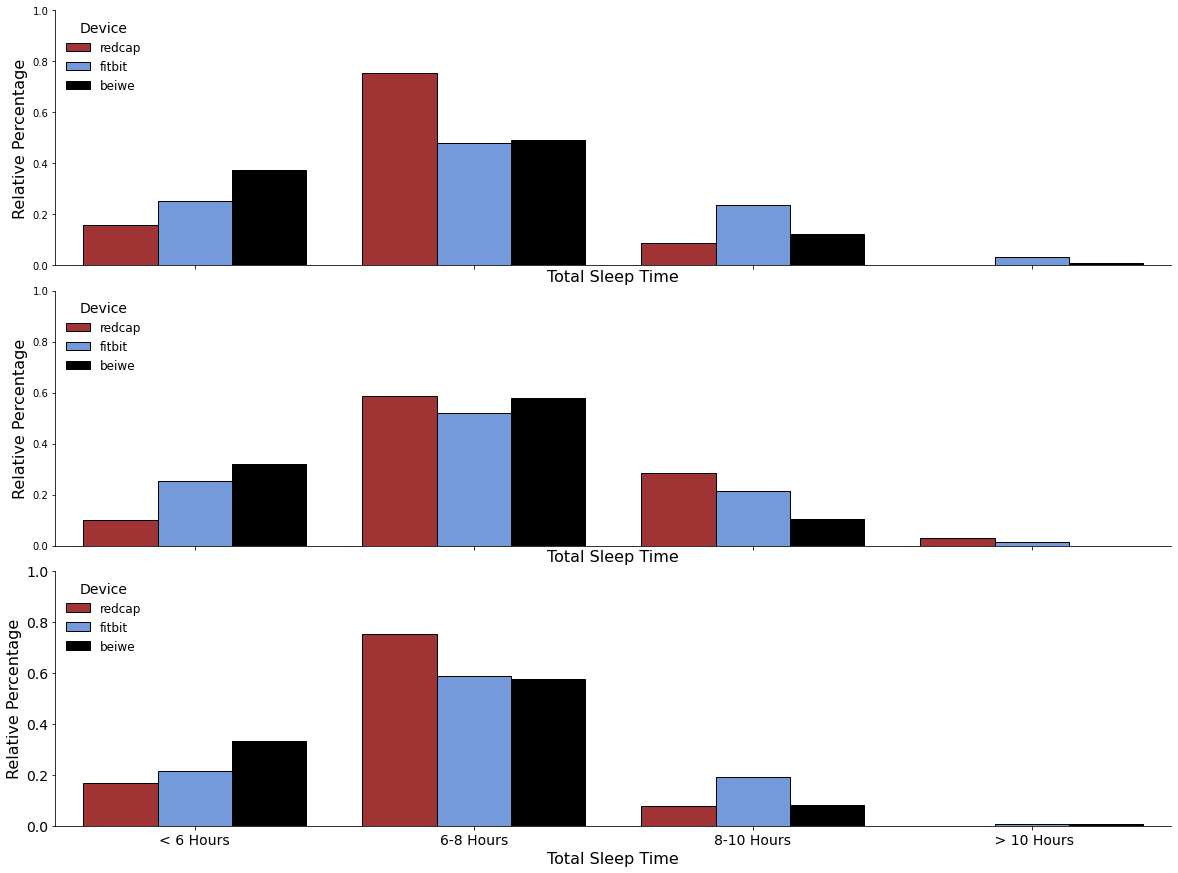

In [230]:
fig, axes = plt.subplots(3,1,figsize=(20,15),sharex=True,gridspec_kw={"hspace":0.1})
for period, ax in zip(["pre","during","followup"],axes.flat):
    temp = all_agg[all_agg["period"] == period]
    bars = sns.barplot(x="tst_rating",y="p",hue="device",data=temp,
                       palette=["firebrick","cornflowerblue","black"],edgecolor="black",ax=ax)
    # x-axis
    bars.set_xlabel("Total Sleep Time",fontsize=16)
    bars.set_xticklabels(["< 6 Hours","6-8 Hours","8-10 Hours", " > 10 Hours"],fontsize=14)
    #plt.xticks(fontsize=14)
    # y-axis
    bars.set_ylabel("Relative Percentage", fontsize=16)
    bars.set_ylim([0,1])
    plt.yticks(fontsize=14)
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    bars.legend(loc="upper left",title="Device",title_fontsize=14,fontsize=12,frameon=False)

# Individual
Now we look for and compare participants who reported answers for each of the three periods.

In [14]:
fb.head()

,tst_fb,redcap,end_date,tst_rating,period
0,6.316667,NaN,2020-05-14,2,during
1,6.533333,NaN,2020-05-15,2,during
2,4.783333,NaN,2020-05-16,1,during
3,6.716667,NaN,2020-05-17,2,during
4,5.850000,NaN,2020-05-18,1,during


In [15]:
bw.head()

,redcap,tst,date,tst_rating,period
0,68,8.0,2020-05-13,2,during
1,28,2.0,2020-05-13,1,during
2,21,6.0,2020-05-13,1,during
3,29,5.3,2020-05-13,1,during
4,48,2.0,2020-05-13,1,during


In [16]:
rc.head()

,redcap,period,tst_rating
0,1,pre,1.0
1,2,pre,1.0
2,4,pre,3.0
3,5,pre,2.0
4,6,pre,2.0
